In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [61]:
df = pd.read_csv('../data/processed/final_ethereum.csv')

In [51]:
df.tail()

,Open,High,Low,Quote asset volume,Number of trades,Taker buy quote asset volume,target
2794,1522.24,1591.47,1504.63,9.012110e+08,2547292,4.765149e+08,1644.18
2795,1566.85,1669.59,1546.06,8.131764e+08,2177800,4.329871e+08,1597.76
2796,1644.19,1649.75,1562.01,9.315987e+08,2597350,4.521358e+08,1623.77
2797,1597.76,1691.50,1595.56,1.062427e+09,2975844,5.465367e+08,1588.78
2798,1623.78,1661.21,1583.12,7.742101e+08,2283302,3.779784e+08,1554.69


In [ ]:
# let's make a price_range column 
# df['price_range'] = df['High'] - df['Low']

In [62]:
df.head()

,Open,High,Low,Quote asset volume,Number of trades,Taker buy quote asset volume,target,price_range
0,301.13,312.18,298.00,2.154655e+06,4522,1.908705e+06,293.96,14.18
1,302.00,311.79,283.94,2.858947e+06,5658,2.240813e+06,290.91,27.85
2,293.31,299.90,278.00,6.200226e+05,1795,4.447136e+05,299.10,21.90
3,289.41,300.53,282.85,7.428479e+05,2038,6.475061e+05,323.29,17.68
4,299.10,346.52,294.60,1.689472e+06,3925,1.297977e+06,309.80,51.92


In [106]:
# sns.pairplot(df)

In [107]:
df.isnull().sum()

Open                            0
High                            0
Low                             0
Close                           0
Volume                          0
Quote asset volume              0
Number of trades                0
Taker buy base asset volume     0
Taker buy quote asset volume    0
price_range                     0
close_to_open                   0
dtype: int64

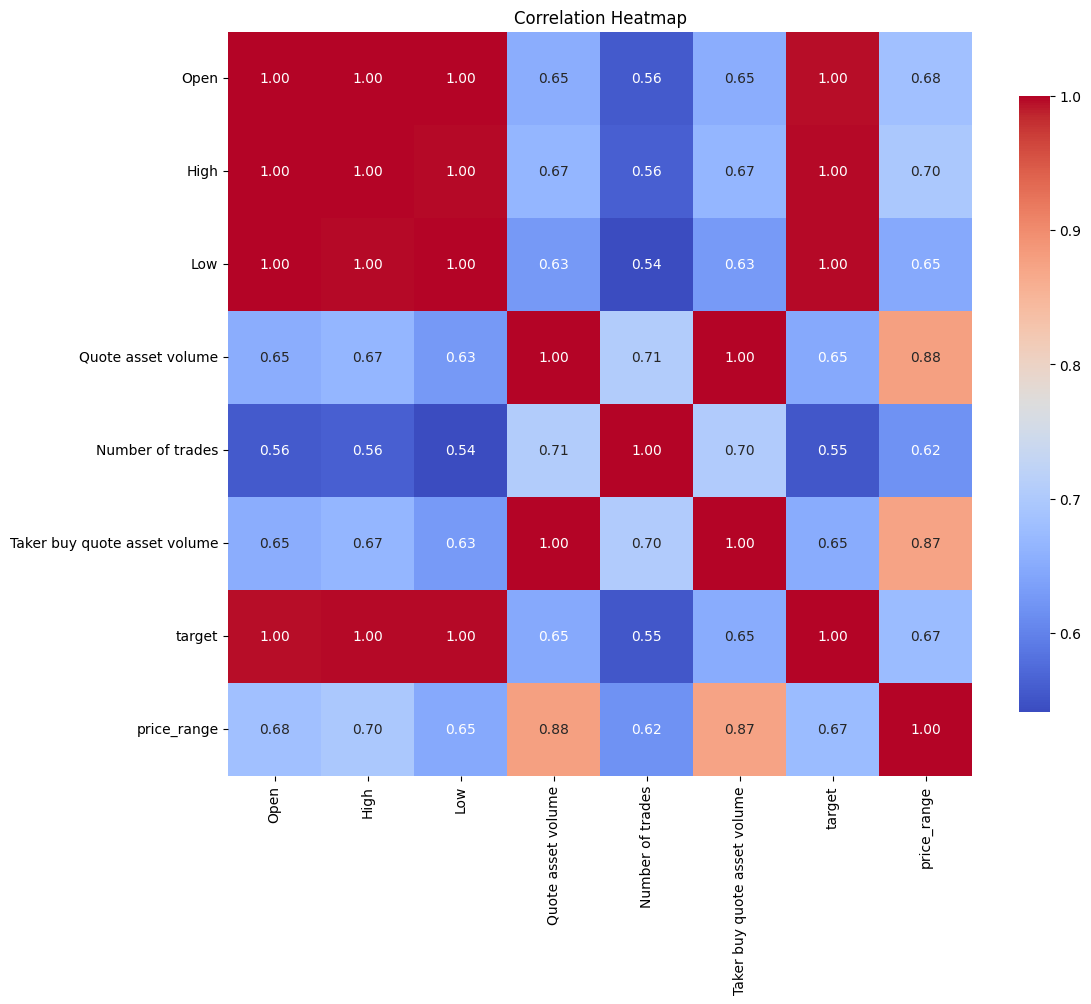

In [54]:
# plot heatmap to know which columns contribute more in predicting the close price
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('../data/processed/final_ethereum.csv')

X = df.drop(columns=["target"]).values
y = df["target"].values

split_index = int(0.8 * len(X))
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

lasso_params = {'alpha': np.logspace(-4, 1, 50)}
lasso_grid = GridSearchCV(
    Lasso(max_iter=10000, random_state=42),
    lasso_params,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
lasso_grid.fit(X_train, y_train)
best_lasso_alpha = lasso_grid.best_params_['alpha']
print(f"Best Lasso alpha: {best_lasso_alpha}")
print(f"Best Lasso CV Score: {-lasso_grid.best_score_}")



ridge_params = {'alpha': np.logspace(-4, 1, 50)}
ridge_grid = GridSearchCV(
    Ridge(max_iter=10000, random_state=42),
    ridge_params,
    cv=cv,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)
ridge_grid.fit(X_train, y_train)
best_ridge_alpha = ridge_grid.best_params_['alpha']
print(f"Best Ridge alpha: {best_ridge_alpha}")
print(f"Best Ridge CV Score: {-ridge_grid.best_score_}")

print("*"*50)

# Train best Lasso model
lasso = Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=42)
lasso.fit(X_train, y_train)
lasso_pred = lasso.predict(X_test)

ridge = Ridge(alpha=best_ridge_alpha, max_iter=10000, random_state=42)
ridge.fit(X_train, y_train)
ridge_pred = ridge.predict(X_test)

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

def evaluate_model(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} MSE: {mse}")
    print(f"{name} RMSE: {rmse}")
    print(f"{name} MAE: {mae}")
    print(f"{name} R2 Score: {r2}")
    print("*"*50)
    return rmse



print("\nModel Performance:")
evaluate_model("Lasso", y_test, lasso_pred)
evaluate_model("Ridge", y_test, ridge_pred)
evaluate_model("Linear Regression", y_test, lr_pred)
print("\nCross-Validation RMSE:")
lasso_cv_rmse = np.sqrt(-cross_val_score(
    Lasso(alpha=best_lasso_alpha, max_iter=10000, random_state=42),
    np.concatenate((X_train, X_test)),
    np.concatenate((y_train, y_test)),
    cv=5,
    scoring='neg_mean_squared_error'
).mean())
print(f"Lasso CV RMSE: {lasso_cv_rmse}")


ridge_cv_rmse = np.sqrt(-cross_val_score(
    Ridge(alpha=best_ridge_alpha, max_iter=10000, random_state=42),
    np.concatenate((X_train, X_test)),
    np.concatenate((y_train, y_test)),
    cv=5,
    scoring='neg_mean_squared_error'
).mean())
print(f"Ridge CV RMSE: {ridge_cv_rmse}")


Best Lasso alpha: 0.010985411419875584
Best Lasso CV Score: 6676.767249899033
Best Ridge alpha: 0.006866488450042998
Best Ridge CV Score: 6668.920638026279
**************************************************

Model Performance:
Lasso MSE: 15892.889328371108
Lasso RMSE: 126.06700332906746
Lasso MAE: 88.85156118795412
Lasso R2 Score: 0.9617528458537465
**************************************************
Ridge MSE: 16645.823729384836
Ridge RMSE: 129.01869527082047
Ridge MAE: 90.8190446941571
Ridge R2 Score: 0.9599408658227663
**************************************************
Linear Regression MSE: 16268.208818245294
Linear Regression RMSE: 127.54688870468496
Linear Regression MAE: 89.69786129270311
Linear Regression R2 Score: 0.9608496178700416
**************************************************

Cross-Validation RMSE:
Lasso CV RMSE: 92.31736527565094
Ridge CV RMSE: 93.11394401888232



First 10 rows of comparison:
    Actual        Lasso        Ridge    LinearReg  Err_Lasso  Err_Ridge  \
0  1611.79  1637.441532  1636.759405  1634.231088  25.651532  24.969405   
1  1645.03  1628.954572  1627.619577  1624.514012  16.075428  17.410423   
2  1633.57  1649.220975  1648.937256  1647.773630  15.650975  15.367256   
3  1632.84  1630.207397  1629.478108  1627.703760   2.632603   3.361892   
4  1580.13  1623.351433  1623.274530  1622.198761  43.221433  43.144530   
5  1567.63  1586.684494  1587.789041  1587.661572  19.054494  20.159041   
6  1566.87  1575.988575  1577.793400  1578.423670   9.118575  10.923400   
7  1539.61  1562.700855  1565.149185  1566.612565  23.090855  25.539185   
8  1552.16  1540.024662  1538.978742  1536.276278  12.135338  13.181258   
9  1554.94  1565.556049  1564.664875  1562.459351  10.616049   9.724875   

   Err_LinearReg  
0      22.441088  
1      20.515988  
2      14.203630  
3       5.136240  
4      42.068761  
5      20.031572  
6      11.5

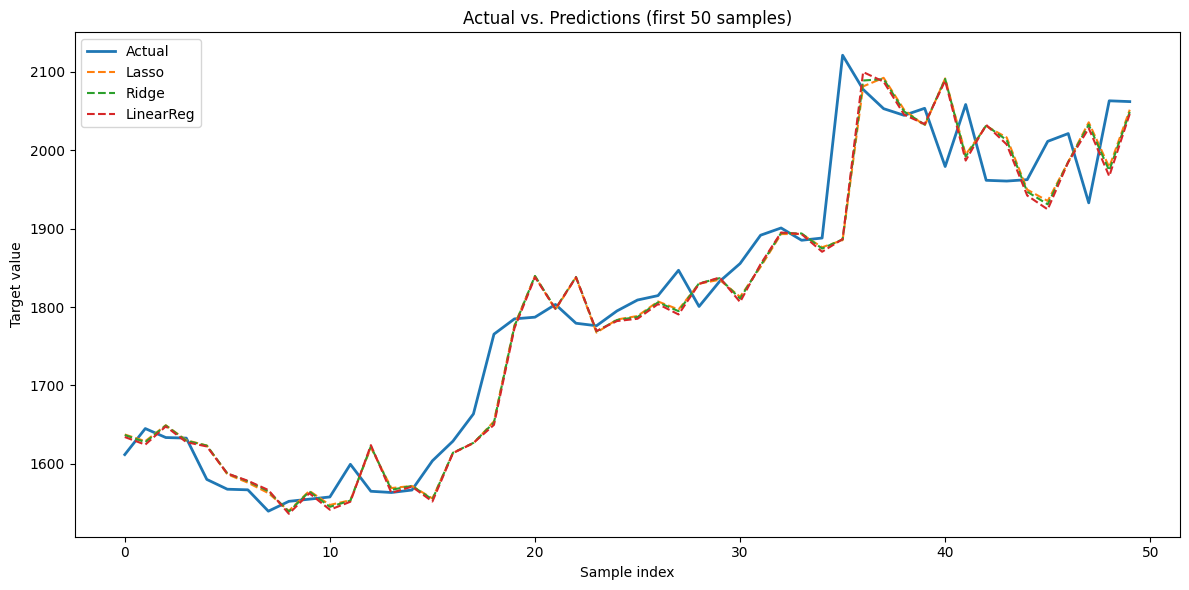

In [69]:
# after your existing code…

# 1. Build a DataFrame comparing actuals & predictions
import pandas as pd

results = pd.DataFrame({
    "Actual":       y_test,
    "Lasso":        lasso_pred,
    "Ridge":        ridge_pred,
    "LinearReg":    lr_pred
})

# Add absolute errors if you like
results["Err_Lasso"]     = (results["Actual"] - results["Lasso"]).abs()
results["Err_Ridge"]     = (results["Actual"] - results["Ridge"]).abs()
results["Err_LinearReg"] = (results["Actual"] - results["LinearReg"]).abs()

print("\nFirst 10 rows of comparison:")
print(results.head(10))

# 2. Plot actual vs. predicted for the first N samples
import matplotlib.pyplot as plt

N = 50  # how many points to plot
plt.figure(figsize=(12, 6))
plt.plot(results["Actual"][:N].values,       label="Actual",        linewidth=2)
plt.plot(results["Lasso"][:N].values,        label="Lasso",         linestyle="--")
plt.plot(results["Ridge"][:N].values,        label="Ridge",         linestyle="--")
plt.plot(results["LinearReg"][:N].values,    label="LinearReg",     linestyle="--")
plt.title(f"Actual vs. Predictions (first {N} samples)")
plt.xlabel("Sample index")
plt.ylabel("Target value")
plt.legend()
plt.tight_layout()
plt.show()


In [76]:
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, KFold, cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import uniform, randint

def evaluate_model(name, y_true, y_pred):
    """Compute and print regression metrics; return RMSE."""
    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"{name:<15} MSE:  {mse:.4f}")
    print(f"{name:<15} RMSE: {rmse:.4f}")
    print(f"{name:<15} MAE:  {mae:.4f}")
    print(f"{name:<15} R2:   {r2:.4f}")
    print("-" * 60)
    return rmse

def train_and_evaluate(name, csv_path):
    """Load data, tune XGBoost, train XGB & LinearRegression, evaluate, return metrics."""
    print(f"\n{'='*10} {name} Dataset {'='*10}\n")
    df = pd.read_csv(csv_path)
    X  = df.drop(columns=["target"]).values
    y  = df["target"].values

    # Split
    split_idx = int(0.8 * len(X))
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Scale
    scaler    = MinMaxScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    # CV setup - use stratified 5-fold CV for better stability
    cv = KFold(n_splits=5, shuffle=True, random_state=42)

    # --- XGBoost advanced hyperparameter tuning with research-proven strategies ---
    # Initialize base XGBoost model
    xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42, tree_method='hist')
    
    # Research-proven parameter distributions
    param_distributions = {
        'n_estimators': randint(100, 1000),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.3),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'min_child_weight': randint(1, 10),
        'gamma': uniform(0, 0.5),
        'reg_alpha': uniform(0, 2),
        'reg_lambda': uniform(0.5, 2)
    }
    
    # Use RandomizedSearchCV which is more efficient for large parameter spaces
    xgb_rs = RandomizedSearchCV(
        xgb_base,
        param_distributions=param_distributions,
        n_iter=30,  # Number of parameter combinations to try
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=1,
        random_state=42
    )
    
    # Fit the randomized search
    xgb_rs.fit(X_train_s, y_train)
    
    # Extract best parameters
    best_params = xgb_rs.best_params_
    print("Best XGB params:")
    for k,v in best_params.items():
        print(f"  {k}: {v}")
    print(f"Best XGB CV MSE: {-xgb_rs.best_score_:.4f}")
    print("-" * 60)

    # Train final XGB with best params and LR
    xgb_final = XGBRegressor(**best_params, objective='reg:squarederror', random_state=42)
    xgb_final.fit(X_train_s, y_train)
    lr = LinearRegression().fit(X_train_s, y_train)

    # Predict
    xgb_pred = xgb_final.predict(X_test_s)
    lr_pred  = lr.predict(X_test_s)

    # Evaluate
    rmse_xgb = evaluate_model("XGBoost", y_test, xgb_pred)
    rmse_lr  = evaluate_model("LinearRegression", y_test, lr_pred)

    # 5‑fold CV RMSE on full dataset for XGB
    all_X_s = np.vstack([X_train_s, X_test_s])
    all_y   = np.concatenate([y_train, y_test])
    xgb_cv_rmse = np.sqrt(-cross_val_score(
        xgb_final,
        all_X_s, all_y,
        cv=cv,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    ).mean())
    print(f"XGBoost 5‑fold CV RMSE: {xgb_cv_rmse:.4f}")
    print("\n" + "="*50 + "\n")

    return {
        "XGB_RMSE":  rmse_xgb,
        "LR_RMSE":   rmse_lr,
        "XGB_CV_RMSE": xgb_cv_rmse
    }

if __name__ == "__main__":
    # Update these paths if needed
    datasets = {
        "Bitcoin":  "../data/processed/final_bitcoin.csv",
        "Ethereum": "../data/processed/final_ethereum.csv"
    }

    summary = {}
    for name, path in datasets.items():
        summary[name] = train_and_evaluate(name, path)

    # Show a quick comparison
    summary_df = pd.DataFrame(summary).T
    print("Summary of Test RMSE and 5‑fold CV RMSE:\n")
    print(summary_df.to_string(float_format="%.4f"))


========== Bitcoin Dataset ==========

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB params:
  colsample_bytree: 0.908897907718663
  gamma: 0.0993578407670862
  learning_rate: 0.01165663513708072
  max_depth: 5
  min_child_weight: 3
  n_estimators: 692
  reg_alpha: 1.4226839054973
  reg_lambda: 2.0803510810624113
  subsample: 0.8423839899124046
Best XGB CV MSE: 1272454.6876
------------------------------------------------------------
XGBoost         MSE:  273381779.8908
XGBoost         RMSE: 16534.2608
XGBoost         MAE:  10095.2783
XGBoost         R2:   0.3453
------------------------------------------------------------
LinearRegression MSE:  3724099.7386
LinearRegression RMSE: 1929.7927
LinearRegression MAE:  1350.6038
LinearRegression R2:   0.9911
------------------------------------------------------------
XGBoost 5‑fold CV RMSE: 1379.9753



========== Ethereum Dataset ==========

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best XGB pa